# Classification of ag plastics across California

Sentinel-2 classification of agricultural plastic use in California based on Harvard students' capstone project and Yuanyuan's internship project

Notebook authored by Annie Taylor, July 2024

Some key changes from previous analyses:
* Using validated training datasets (edited, added precise dates)
* Using different cloud-masking algorithm
* Using updated index equations
* Random stratified sample within polygons instead of sampling every point

### Set up ee api and packages

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
from IPython.display import display, HTML
from datetime import datetime, timedelta
from sklearn.metrics import ConfusionMatrixDisplay
import geopandas as gpd
import altair as alt
import rasterio #used for pt sampling in 8
from rasterio.plot import show
import seaborn as sns

In [2]:
# ee.Authenticate()
ee.Initialize(project='ee-tnc-annietaylor')

### Load data

In [3]:
# Training data - local
# Import the csvs with lat/longs as dfs (could all be one csv/df, keeping separate for testing)
train_path = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/"
santamaria = pd.read_csv(train_path + 'SantaMaria_val_o.csv')
mendocino = pd.read_csv(train_path + 'MendocinoCounty_val_o.csv')
# watsonville = pd.read_csv(train_path + 'Watsonville_val.csv')
watsonville = pd.read_csv(train_path + 'Watsonville_val_BM.csv')
# replace 'black mulch' with 'blackmulch' to avoid issues with space in label
watsonville['Type'] = watsonville['Type'].replace('black mulch', 'blackmulch')
oxnard_original = pd.read_csv(train_path + 'YYT_RElabeled_points_date_fixed.csv')
# Drop the 'TARGET_FID' column from the 'oxnard' DataFrame - shouldn't need this anymore
# oxnard_original = oxnard_original.drop('TARGET_FID', axis=1)
oxnard_add = pd.read_csv(train_path + 'Oxnard_additional_val.csv')
oxnard = pd.concat([oxnard_original, oxnard_add], axis=0, ignore_index=True)
# importing new other trees dataset
othertrees = pd.read_csv(train_path + 'Brandee_Other_Trees_2025.csv')


# Print out unique 'Type' values for each df to check for typos
print('Checking for typos in the Type column:')
# all_dfs = [santamaria, mendocino, watsonville, oxnard]
all_dfs = [santamaria, watsonville, oxnard, othertrees]
for df in all_dfs:
    print(df['Location'].iloc[0])
    print('\tunique types', df['Type'].unique())
    print('\tnumber of rows:', df.shape[0])

all_data = pd.concat(all_dfs, axis=0, ignore_index=True)
print('Total number of training points:', all_data.shape[0])
print('\tunique types', all_data['Type'].unique())
print('Number of rows in each class of Type:')
print(all_data['Type'].value_counts())

# EE data
assets = 'projects/ee-annalisertaylor/assets/TNC/agplastics/'
# California boundary
ca = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.equals('NAME', 'California'))
# Agricultural areas from CA DWR's crop maps, 2019 to 2022 inclusive (10m raster)
crops = ee.Image('projects/ee-annalisertaylor/assets/TNC/agplastics/dwr_allyears')

# County boundaries for spatial filtering 
county_bnd = ee.FeatureCollection("TIGER/2016/Counties").filterBounds(ca)
# grab whichever counties you want
ventura = county_bnd.filter(ee.Filter.eq('NAME', 'Ventura'))
mendo = county_bnd.filter(ee.Filter.eq('NAME', 'Mendocino'))
cruz = county_bnd.filter(ee.Filter.eq('NAME', 'Santa Cruz'))
santabarbara = county_bnd.filter(ee.Filter.eq('NAME', 'Santa Barbara'))
kern = county_bnd.filter(ee.Filter.eq('NAME', 'Kern'))
# to read all the county options
# county_df = geemap.ee_to_df(county_bnd)
# pd.set_option('display.max_rows', 75)
# county_df['NAME']

# Encode labels - ee classifier requires numeric class labels
class_mapping = {'hoop': 0, 'mulch': 1, 'other': 2, 'blackmulch': 3, 'greenhouse': 4}
# only watsonville has greenhouse points right now, santa maria has a separate (unimported) dataset


Checking for typos in the Type column:
Santa Maria
	unique types ['hoop' 'mulch' 'other']
	number of rows: 1748
Watsonville
	unique types ['mulch' 'hoop' 'other' 'blackmulch' 'greenhouse']
	number of rows: 2346
Oxnard
	unique types ['hoop' 'mulch' 'blackmulch' 'other']
	number of rows: 1533
CA
	unique types ['other']
	number of rows: 165
Total number of training points: 5792
	unique types ['hoop' 'mulch' 'other' 'blackmulch' 'greenhouse']
Number of rows in each class of Type:
Type
other         2682
mulch         1527
hoop          1407
blackmulch     149
greenhouse      27
Name: count, dtype: int64


In [4]:
othertrees

Location       Region   Type        Date   Latitude   Longitude
0         CA  Morgan Hill  other   5/26/2023  37.188061 -121.725901
1         CA  Morgan Hill  other   5/26/2023  37.189068 -121.724510
2         CA  Morgan Hill  other   5/26/2023  37.190223 -121.722561
3         CA  Morgan Hill  other   5/26/2023  37.187451 -121.719603
4         CA  Morgan Hill  other   5/26/2023  37.189402 -121.726455
..       ...          ...    ...         ...        ...         ...
160       CA     Maricopa  other  12/23/2022  34.903219 -119.589028
161       CA     Maricopa  other  12/23/2022  34.900812 -119.591903
162       CA     Maricopa  other  12/23/2022  34.900519 -119.601198
163       CA     Maricopa  other  12/23/2022  34.899991 -119.603158
164       CA     Maricopa  other  12/23/2022  34.902722 -119.601180

[165 rows x 6 columns]

## 1. Process Sentinel-2 Imagery

### Cloud filter the image collection

In [5]:
startDate = ee.Date.fromYMD(2010, 1, 1) # setting these to be inclusive for now, can change
endDate = ee.Date.fromYMD(2025, 10, 1)

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filter(ee.Filter.date(startDate, endDate)) \
    .filter(ee.Filter.bounds(ca)) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 92))
    # .filter(ee.Filter.lt('CLOUDY_PIXEL_OVER_LAND_PERCENTAGE', 92)) #trying another property for clouds covering land
    # this causes an error bc it's not a property until more recently    

#### Cloud filtering with the s2_cloudless collection

In [6]:
# cloud mask using the cloudless image collection, pulling from EE documentation example
s2cloud = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
s2cloud = s2cloud.filterBounds(ca)
MAX_CLOUD_PROBABILITY = 15

def maskClouds(img):
    clouds = ee.Image(img.get('cloud_mask')).select('probability')
    isNotCloud = clouds.lt(MAX_CLOUD_PROBABILITY)
    return img.updateMask(isNotCloud)

# Masks for the 10m bands can include bad data at scene edge; apply masks from the 20m and 60m bands too
def maskEdges(s2_img):
    return s2_img.updateMask(s2_img.select('B8A').mask().updateMask(s2_img.select('B9').mask()))

# So I can investigate how this is performing above plastic cover
def addCloudless(img):
    cloud_prob = ee.Image(img.get('cloud_mask')).select('probability')
    return img.addBands(cloud_prob.rename('cloud_probability'))

# Filter s2cloud to same region, fix 10m pixels at edges
s2_mask = s2.map(maskEdges)

# Join S2 with cloud probability dataset to add cloud mask
# cloudless image is saved as a property called 'cloud_mask' in the original image
s2sr_cloudmask = ee.Join.saveFirst('cloud_mask').apply(primary=s2_mask, secondary=s2cloud, \
                            condition=ee.Filter.equals(leftField='system:index', rightField='system:index'))

# create the cloud masked image collection
s2_cldmsk = ee.ImageCollection(s2sr_cloudmask).map(maskClouds)

# create an image collection with the cloud probability band, not yet masked
# this is for testing to see what values certain pixels have
s2_cld_test = ee.ImageCollection(s2sr_cloudmask).map(addCloudless)

#### Cloud filtering with the QA band 
Checked this out after seeing problems with the s2_cloudless filter, but apparently this band doesn't contain any info from feb 2022 to feb 2024 so it's not usable

In [7]:
def mask_s2_clouds(image):
   qa = image.select('QA60')
   # Bits 10 and 11 are clouds and cirrus, respectively.
   cloud_bit_mask = 1 << 10
   cirrus_bit_mask = 1 << 11
   # Both flags should be set to zero, indicating clear conditions.
   mask = (qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0)))
   return image.updateMask(mask)

s2_qa_cldmsk = s2.map(mask_s2_clouds)

#### Cloud filtering with MSK_CLDPRB band

In [8]:
cloud_threshold = 10

def mask_s2_clouds_cm(image):
   cm = image.select('MSK_CLDPRB')
   isNotCloud = cm.lt(MAX_CLOUD_PROBABILITY)
   return image.updateMask(isNotCloud)

s2_cm_cldmsk = s2.map(mask_s2_clouds_cm)

#### Cloud filtering with the SCL band

In [9]:
# 8 = Clouds Medium Probability
# 9 = Clouds High Probability
# 10 = Cirrus

def mask_s2_clouds_scl(image):
    scl = image.select('SCL')
    isNotCloud = scl.neq(8).And(scl.neq(9).And(scl.neq(10)))
    return image.updateMask(isNotCloud)

s2_scl_cldmsk = s2.map(mask_s2_clouds_scl)

### Vis params

In [10]:
rgbVis = {'min': 400, 'max': 1500, 'bands': ['B4', 'B3', 'B2']}
RPGI_viz = {'min': -0.9, 'max': -0.4, 'palette': ['#4d004b', '#f7fcfd']}
NDTI_viz = {'min': 0.0, 'max': 0.2, 'palette': ['white', 'yellow', 'orange']}
# visualize the classified plastic
plastic_viz = {'palette': ['FF5733', 'F4F31D', '2596be', '#333333'], 'min': 0, 'max': 3}
et_viz = {
  'min': 0,
  'max': 100,
  'palette': [
    '9e6212', 'ac7d1d', 'ba9829', 'c8b434', 'd6cf40', 'bed44b', '9fcb51',
    '80c256', '61b95c', '42b062', '45b677', '49bc8d', '4dc2a2', '51c8b8',
    '55cece', '4db4ba', '459aa7', '3d8094', '356681', '2d4c6e',
  ]
}

### Add VIs

In [11]:
def addVIs(image):
    image = image.addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))
    # image = image.addBands(image.normalizedDifference(['B8', 'B12']).rename('NBR')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B8', 'B11']).rename('NDMI')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B3', 'B8']).rename('NDWI'))
    # image = image.addBands(image.expression("2.5 * ((b('B8') - b('B4')) / (b('B8') + 6 * b('B4') - 7.5 * b('B2') + 1))").rename('EVI'))
    image = image.addBands(image.normalizedDifference(['B11', 'B12']).rename('NDTI')) # swir1 and swir2, both 20m, tillage index
    image = image.addBands(image.expression("(100 * b('B2') * (b('B8') - b('B4')))/(1 - ((b('B2') + b('B3') + b('B8')) / 3))").rename('PGI')) # all 10m
    image = image.addBands(image.expression("b('B2')/(1 - ((b('B2') + b('B3') + b('B8')) / 3))").rename('RPGI')) 
    image = image.addBands(image.normalizedDifference(['B11', 'B4']).rename('PMLI')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B11', 'B8']).rename('NDBI')) # one band at 20m   
    return image

def adjPGI(image):
    # TODO check if this threshold for NDBI is too high
    # set all bands in the image to 0 where NDVI is higher than 0.73 OR when NDBI is higher than 0.005
    PGI_adj = image.where(image.select('NDVI').gt(0.73), 0)
    PGI_adj = PGI_adj.where(PGI_adj.select('NDBI').gte(0.005), 0)
    # extract the 'PGI' band from that modified image, and add it to the original image with a new name
    image = image.addBands(PGI_adj.select('PGI').rename('PGI_adj'))   
    return image

# not using this right now, keeping it as a useful example for downsampling the NIR band
# will be more precise if we decide to publish any of these data
def addNBR_RS(image):
    # reduces the resolution of the NIR band (10m) to match the SWIR band (20m)
    #   using the mean of all pixels within the larger pixel
    swir = image.select('B12')
    swir_projection = swir.projection()
    nir = image.select('B8').reduceResolution(reducer=ee.Reducer.mean(), maxPixels=16).reproject(crs=swir_projection)
    js_math_exp = 'c = (a-b) / (a+b)'
    js_math_img = ee.Image().expression(
        expression=js_math_exp, opt_map={'a': nir, 'b': swir}
    ).rename('NBR_RS')
    image = image.addBands(js_math_img)
    return image


### Build the collection

In [12]:
# one for each method of cloud filtering, for comparison
# s2_cloudless
processedCollection = s2_cldmsk.map(addVIs)
processedCollection = processedCollection.map(adjPGI)
# scl map
processedCollection_scl = s2_scl_cldmsk.map(addVIs)
processedCollection_scl = processedCollection_scl.map(adjPGI)
# other cloud masks for testing
processedCollection_qa = s2_qa_cldmsk.map(addVIs)
processedCollection_cm = s2_cm_cldmsk.map(addVIs)

# Change the working image collection to the SCL cloud filtered one
processedCollection = processedCollection_scl

# print(processedCollection.size().getInfo())
# print(processedCollection.first().bandNames().getInfo())

In [13]:
# Select bands to sample from the sentinel-2 images
bands = [
    'B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12',
    'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI', 'NDBI', 'PGI_adj', 'NDWI', 'NDMI'
]

#### Match training data dates to clear sentinel-2 images

In [14]:
# matching training data to sentinel images, first clear image on or after the point date
date_matching_wats = {
    'points_date': ['2020-09-26', '2021-09-27', '2022-09-11', '2023-04-12', '2019-11-17', '2023-07-09'],
    'image_date': ['2020-09-26', '2021-10-01', '2022-09-16', '2023-04-14', '2019-12-16', '2023-07-28'],
    'location': ['Watsonville']*6
}
date_matching_mendo = {
    'points_date': ['2021-06-02'],
    'image_date': ['2021-06-06'],
    'location': ['Mendocino']*1
}
date_matching_maria = {
    'points_date': ['2022-08-26', '2023-05-05', '2022-03-10', '2021-02-06'],
    'image_date': ['2022-08-29', '2023-05-11', '2022-03-12', '2021-02-10'],
    'location': ['Santa Maria']*4
}
date_matching_oxnard = {
    # as of 11.13.24, all oxnard dates are added
    # For 5-6-23, can use 5/11 (has clouds but not on those points specifically) or 4/21,
    # cloud free but 15 days prior
    # for 8-1-2023, clouds far from those specific points, take care if adding more points
    'points_date': ['2023-10-17', '2023-05-06', '2023-11-09', '2019-05-17', '2022-06-13',
                    '2021-07-13', '2022-10-01', '2022-11-01', '2019-10-14', '2020-02-15',
                    '2023-08-01', '2021-02-28', '2023-05-07', '2019-08-19', '2023-05-11',
                    '2019-04-01', '2022-09-21', '2018-11-19'],
    'image_date': ['2023-10-28', '2023-05-11', '2023-11-09', '2019-05-17', '2022-06-15',
                   '2021-07-15', '2022-10-03', '2022-11-02', '2019-10-24', '2020-02-16',
                   '2023-08-01', '2021-03-02', '2023-05-06', '2019-08-20', '2023-05-11',
                   '2019-04-02', '2022-09-23', '2018-12-15'],
    'location': ['Oxnard']*18
}

date_matching_other = {
    'points_date': ['2023-05-26', '2023-06-29', #morgan hill
                    '2023-04-27', '2022-03-10', #santa maria
                    '2023-11-09', #oxnard
                    '2023-07-13', '2023-07-08', #santa barbara
                    '2023-08-01', '2022-10-08', '2022-12-23'#maricopa
                    ],
    'image_date': ['2023-06-03', '2023-07-03',
                   '2023-05-11', '2022-03-12',
                   '2023-11-09',
                   '2023-07-15', '2023-07-10',
                   '2023-08-01', '2022-10-08', '2023-01-06'
                   ],

    'location': ['CA']*10
}

# Convert combined dictionary to dataframe
dates_wats = pd.DataFrame.from_dict(date_matching_wats)
dates_mendo = pd.DataFrame.from_dict(date_matching_mendo)
dates_maria = pd.DataFrame.from_dict(date_matching_maria)
dates_oxnard = pd.DataFrame.from_dict(date_matching_oxnard)
dates_other = pd.DataFrame.from_dict(date_matching_other)
# print(dates_wats, '\n', dates_mendo, '\n', dates_maria, '\n', dates_oxnard)

# combine dfs vertically
date_matching = pd.concat([dates_wats, dates_mendo, dates_maria, dates_oxnard, dates_other], axis=0, ignore_index=True)
# print(date_matching.sort_values(by='points_date'))

co = santabarbara # ventura, mendo, cruz, santabarbara

# option to import points from csv to show them on the map
# watsonville_points = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/Watsonville_val_BM.csv"
# oxnard_points = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/YYT_RElabeled_points_date_fixed.csv"
# oxnard_points = "N:/OCEANS_Program/Plastics/Agricultural_Plastics/Validated Training Data/oxnard_onedate.csv"

date = '2022-03-12'
nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
oneday = processedCollection.filterDate(date, nextday).median()
oneday_original = s2.filterDate(date, nextday).median()

m = geemap.Map()
# m.add_basemap('HYBRID')
m.addLayer(oneday_original, rgbVis, 'original image')
m.addLayer(oneday, rgbVis, 'cloud filtered')
# m.add_points_from_xy(oxnard_points, x="Longitude", y="Latitude")
m.centerObject(co, 10)
# m

##### calculate date gaps for manuscript

In [15]:
# # Convert columns to datetime format
# date_matching['points_date'] = pd.to_datetime(date_matching['points_date'])
# date_matching['image_date'] = pd.to_datetime(date_matching['image_date'])

# # Calculate the difference in days
# date_matching['days_difference'] = (date_matching['image_date'] - date_matching['points_date']).dt.days

# print(date_matching)
# print(date_matching['days_difference'].describe())

#### Investigate cloud filtering issues

In [16]:
# processedCollection = final collection with VIs added
# processedCollection2 = final collection with VIs added, using QA60 band for cloud filtering
# s2_cldmsk = cloud filtered version
# s2_qa_cldmsk = cloud filtered version using QA60 band
# s2_cm_cldmsk = cloud filtered version using MSK_CLDPRB band
# s2_cld_test = s2 with s2_cloudless data joined, not yet filtered
# s2 = original collection, filtered by date/ca/image cloudiness lt 92

# co = santabarbara # ventura, mendo, cruz, santabarbara
# images_original = processedCollection.filterBounds(co)
# # test_s2 = s2.filterBounds(co)
# images_cloudless = s2_cld_test.filterBounds(co) # get the original image with s2_cloudless probability added
# images_cm = processedCollection_cm.filterBounds(co)
# images_scl = processedCollection_scl.filterBounds(co)

# start = '2020-09-26' # sf cloudy image = '2022-01-01' 
# end = '2022-03-30'

# original = images_original.filterDate(start, end).first()
# original_cloudless = images_cloudless.filterDate(start, end).first()
# cm = images_cm.filterDate(start, end).first()
# scl = images_scl.filterDate(start, end).first()

# m = geemap.Map()
# m.addLayer(original, rgbVis, 'cloud filtered')
# m.addLayer(cm, rgbVis, 'cloud filtered CLDPRB')
# m.addLayer(scl, rgbVis, 'cloud filtered SCL')
# m.addLayer(original_cloudless, rgbVis, 'original image')
# m.centerObject(co, 10)
# m

### Evapotranspiration data

In [17]:
et = ee.ImageCollection('OpenET/ENSEMBLE/CONUS/GRIDMET/MONTHLY/v2_0').filterBounds(ca).select('et_ensemble_mad')

# https://developers.google.com/earth-engine/datasets/catalog/OpenET_ENSEMBLE_CONUS_GRIDMET_MONTHLY_v2_0#bands
# Using the ensemble value of ET = 'et_ensemble_mad'

# The ET data only goes through the end of 2023, which is okay with our current training data
# the function will error if we try to sample in 2024 (probably an 'image has no bands' error)

date = ee.Date('2022-07-17')
date = ee.Date(date.format('yyyy-MM-01'))

data = et.filterDate(date, date.advance(1, 'month'))
# display(data)

m = geemap.Map()
m.setCenter(-119.17, 34.19, 6)
m.addLayer(data, et_viz, 'Ensemble ET')
# m

## 2. Sample each feature collection to build training dataset
This method uses image matching to ensure there are no cloudy pixels in the training data

Skip to 2b for faster running code if you haven't made changes to imagery / sampling methods

In [18]:
def sample_dates(df):
    # add a 'class' column to the df by mapping the 'Type' column to numeric values
    df['class'] = df['Type'].map(class_mapping)
    # Format dates to YYYY-MM-DD
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

    # print('pre-filter', df['Date'].unique())
    # print(df.shape[0])

    # Drop greenhouse, drop points from before 2018-05-09
    df = df[df["Type"]!="greenhouse"]
    df = df[df['Date'] > '2018-05-09']
    # print('post-filter', df['Date'].unique())
    # print(df.shape[0])
    
    # get the location of the df to be sampled
    location = df['Location'].iloc[0]
    # filter the date_matching df to this location
    date_matching_loc = date_matching[date_matching['location'] == location]
    # Filter for only dates that have a matched sampling image, should be all now
    df = df.loc[df['Date'].isin(date_matching_loc['points_date'])]

    dates = df['Date'].unique()
    # print('post-filter', dates)

    all_area_data = []

    # Iterate through all of the dates in the df
    for date in dates:
        # Get df rows for that date
        df_date = df[df["Date"]==date]
        fc_date = geemap.df_to_ee(df_date, latitude='Latitude', longitude='Longitude')
        # Get image date from the date_matching df
        image_date = date_matching_loc.loc[date_matching_loc['points_date'] == date, 'image_date'].iloc[0]
        # Filter images to only that one corresponding sampling date
        image_nextdate = ee.Date(image_date).advance(1, 'day').format('YYYY-MM-dd')
        sample_image = processedCollection.filterDate(image_date, image_nextdate).median()
        # Sample that image to the fc, keeping ‘class’ property
        data = sample_image.select(bands).sampleRegions(
            collection=fc_date,
            properties=['class', 'Latitude', 'Longitude'],
            scale=10, #Reduces points within 10m of each other
            geometries=True
        )

        # Also sample the monthly ET (30m scale, from landsat and other weather data)
        et_date = ee.Date(ee.Date(image_date).format('yyyy-MM-01')) #convert to first of month for ET data
        et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')
        data = et_img.sampleRegions(
            collection=data,
            scale=30, #I believe 30m scale reduces points within 30m of each other
            geometries=True
        )
        # Add point date, sampled image date, and location as a property to each feature in the feature collection
        data = data.map(lambda feature: feature.set({
            'date': date,
            'image_date': image_date,
            'location': location
            }))

        # Append to list of fcs for each date
        all_area_data.append(data)

    # Flatten into one fc for the dataset
    area_fc = ee.FeatureCollection(all_area_data).flatten()
    return area_fc

In [19]:
test = sample_dates(othertrees)
print(test.size().getInfo())
# test_df = geemap.ee_to_df(test)
# test_df
# filtered = date_matching[date_matching['location'] == 'Oxnard']
# print(filtered)
# display('after sampling', test_df['class'].value_counts())
# display('before sampling', oxnard['Type'].value_counts())
# print(class_mapping)

# make a df with manually entered points
# but you would also have to add to date_matching for any new image dates
# data_points = [
#     ['Oxnard', '8/1/2023', 'mulch', -119.257339, 34.260933]
# ]
# other_points = pd.DataFrame(data_points, columns=['Location', 'Date', 'Type', 'Longitude', 'Latitude'])
# test

# santamaria printout says 298, excel file is 768. total rows matches. my filtering function is 768.
# mendo is right (none)
# watsonville printout says 65, excel file is 464. total rows matches. my filtering function is 464 (accounting for greenhouse points)
# oxnard printout says 578, excel files (2) are 0. total rows 1474 + 59 = 1533 matches. my filtering function is 1533.
# so all of the filtering is working as I expect

165


In [20]:
# On 9.20.24, removed mendocino training data from the model 
# mendo_training = sample_dates(mendocino)
watsonville_training = sample_dates(watsonville)
santamaria_training = sample_dates(santamaria)
oxnard_training = sample_dates(oxnard)
# On 1.30.25 added other trees dataset
othertrees_training = sample_dates(othertrees)

# Combine all data - list of feature collections
all_data = []
# all_data.append(mendo_training)
all_data.append(watsonville_training)
all_data.append(santamaria_training)
all_data.append(oxnard_training)
all_data.append(othertrees_training)

# generate a random number column for training/validation split
data = ee.FeatureCollection(all_data).flatten().randomColumn(seed=0)

In [21]:
# save the fc as an asset to drastically speed up later anaylsis
# have to delete this asset first, can't overwrite it

# asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/labeled_point_data_matched_ET_BM_o_nm_ox_all_trees'
# task = ee.batch.Export.table.toAsset(
#     collection=data,
#     description='Export training data to asset',
#     assetId=asset_id
# )
# task.start()

## 2b Import fc instead of building it

In [22]:
# import the fc back
asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/labeled_point_data_matched_ET_BM_o_nm_ox_all_trees'
data = ee.FeatureCollection(asset_id)

### 2c violin plots

In [23]:
data_df = geemap.ee_to_df(data)
class_mapping_reversed = {v: k for k, v in class_mapping.items()}
data_df['Type'] = data_df['class'].map(class_mapping_reversed)
# data_df.head()

In [24]:
# select the band of interest for plotting
boi = "NDTI"
# NDTI, ET, RPGI, B12, NDVI, NDMI, B11, PGI, B6, NDBI, B2, NDWI
# NDTI	7.942652
# B12	6.935348
# B11	6.820965
# RPGI	6.612448
# B2	6.566569
# NDMI	6.226701
# PGI	6.178141
# ET	

In [25]:
chart = alt.Chart(data_df).mark_boxplot().encode(
    alt.X("Type:N", sort=['other', 'hoop', 'mulch', 'blackmulch']),
    alt.Y(boi).scale(zero=False),
    alt.Color("Type:N"),
    alt.Tooltip("image_date:T")
).properties(width=300)

countlabel = alt.Chart(data_df).mark_text(align='center', dy=-130, fontWeight=100, fontSize=10).encode(
    x='Type:N',
    text='label:N'
).transform_joinaggregate(
    n_count = 'count(Type)',
    groupby=['Type']
).transform_calculate(
    label = "'n = ' + datum.n_count"
)

# chart + countlabel

In [26]:
chart2 = alt.Chart(data_df, width=100).transform_density(
    boi,
    as_=[boi, 'density'],
    groupby=['Type']
).mark_area(orient='horizontal').encode(
    alt.X('density:Q')
        .stack('center')
        .impute(None)
        .title(None)
        .axis(labels=False, values=[0], grid=False, ticks=True),
    alt.Y(boi),
    alt.Color('Type:N'),
    alt.Column('Type:N', sort=['other', 'hoop', 'mulch', 'blackmulch'])
        .spacing(0)
        .header(titleOrient='bottom', labelOrient='bottom', labelPadding=0)
).configure_view(
    stroke=None
)

# chart2
display(chart + countlabel, chart2)

alt.LayerChart(...)

alt.Chart(...)

## 3. Split training and validation data

#### merge blackmulch class into mulch class
Slightly higher overall accuracy and higher recall (aka fewer mulch points missed)

In [27]:
# combine black mulch and mulch classes as this slightly improved model performance
# data.first().get('class').getInfo()
data = data.map(lambda feature: feature.set('class', ee.Algorithms.If(ee.Number(feature.get('class')).eq(3), 1, feature.get('class'))))

In [28]:
# Process data (1): Train test split
# print(f"Total number of labeled data:", data.size().getInfo())
split = 0.7
training = data.filter(ee.Filter.lt('random', split))
validation = data.filter(ee.Filter.gte('random', split))
# print(f"Number of training points: {training.size().getInfo()}")
# print(f"Number of validation points: {validation.size().getInfo()}")

#### Training data stats

In [29]:
# convert to dfs for easier stats
# training_df = geemap.ee_to_df(training)
# validation_df = geemap.ee_to_df(validation)

# print(f"Number of training points: {training_df.shape[0]}")
# print(f"Number of validation points: {validation_df.shape[0]}")

# Check number of data in each county
# print("Number of training points:", training_df['county'].value_counts())
# print("Number of validation points:", validation_df['county'].value_counts())

#### Address spatial autocorrelation
- Remove points within 30 meters of each other between the training and validation datasets
- DOES NOT ADDRESS SPATIAL AUTOCORRELATION W/IN THESE DATASETS and also the fact that many of these points are from different dates :/ 

##### this is where kirk and I left off #2

In [30]:
# Process data (2): Address autocorrelation correction
# TODO how are we addressing spatial autocorrelation within each dataset?
# right now this is simply removing any training data points within 30m of a validation point
distFilter = ee.Filter.withinDistance(
    distance=30,
    leftField='.geo',
    rightField='.geo',
    maxError=10
)
join = ee.Join.inverted()
training = join.apply(training, validation, distFilter)
# print(f"Number of training points after removing autocorrelation: {training.size().getInfo()}")


# only need to worry about this within dates, within the same week for example
# if val point is too close to training point, we're not actually testing our model
# should we validate points from new fields -- this is kirk's preference
# use lat long and time to cluster points, break this into n groups
#  wihtin this time period, 
# geographic clusters per year and per region
# or i could set a max number of points per cluster

In [31]:
# convert to dfs for easier stats again
training_df = geemap.ee_to_df(training)
# Check number of training data in each region again
display("Number of training points:", training_df['location'].value_counts())
# training_df.head(5)

'Number of training points:'

location
Watsonville    800
Oxnard         795
Santa Maria    629
CA             114
Name: count, dtype: int64

In [32]:
# print("Number of training points of each class:", training_df['class'].value_counts())
for class_name, class_id in class_mapping.items():
   filtered_df = training_df[training_df['class'] == class_id]
   print(f"Number of points labeled {class_name}: {filtered_df.shape[0]}")

Number of points labeled hoop: 529
Number of points labeled mulch: 552
Number of points labeled other: 1257
Number of points labeled blackmulch: 0
Number of points labeled greenhouse: 0


## 4. Train and Evaluate Models

### Random Forest

In [33]:
# bands to train the model on
bands_tr = [
    'B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12',
    'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI', 'NDBI', 'PGI_adj', 'NDWI', 'NDMI',
    'ET'
]

In [34]:
# Train and test the RF model
# trying it with probability output
trained_RF = ee.Classifier.smileRandomForest(50).train(training, 'class', bands_tr)
trainAccuracy_RF = trained_RF.confusionMatrix()

classifications_RF = validation.classify(trained_RF)
validationAccuracy_RF = classifications_RF.errorMatrix('class', 'classification')

# print out accuracy information
print(f"\tTraining accuracy:{trainAccuracy_RF.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_RF.accuracy().getInfo()}")
# trained_RF.explain()
# takes about 2 min to run if you have recreated instead of importing the training data, otherwise super fast
# classifications_RF

	Training accuracy:0.9965782720273738
	Validation accuracy:0.9268668206312548


In [35]:
# this gives f score for each class (hoop, mulch, other) (blackmulch combined now)
validationAccuracy_RF.fscore().getInfo()

[0.940959409594096, 0.8991825613079019, 0.9364599092284417]

#### Confusion matrices

Text(0.5, 1.0, 'RF Confusion Matrix (92.69% Accuracy)')

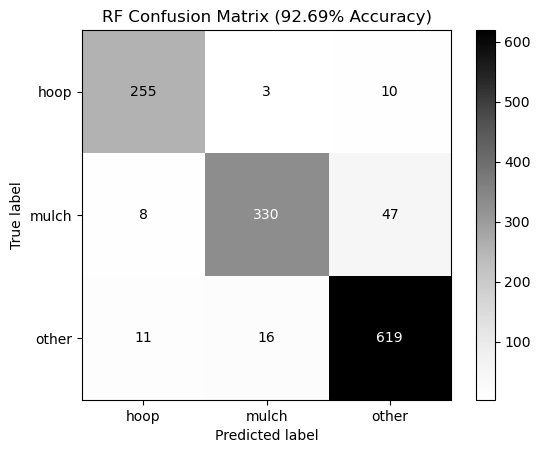

In [36]:
# Plot confusion matrix
# display_labels = ['hoop', 'mulch', 'other', 'blackmulch']
display_labels = ['hoop', 'mulch', 'other']

cm_RF = np.array(validationAccuracy_RF.getInfo())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF, display_labels=display_labels)
disp.plot(cmap=plt.cm.Greys)
disp.ax_.set_title(f"RF Confusion Matrix ({validationAccuracy_RF.accuracy().getInfo():.2%} Accuracy)")

In [37]:
# def plot_each_county_cm(cm_Counties):
#   f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

#   for i, (county, cm) in enumerate(cm_Counties.items()):
#       disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm.getInfo()), display_labels=display_labels)
#       disp.plot(ax=axes[i], cmap=plt.cm.Blues)
#       disp.ax_.set_title(f"{county} ({cm.accuracy().getInfo():.2%} Accuracy)")
#       disp.im_.colorbar.remove()
#       disp.ax_.set_xlabel('')
#       if i!=0:
#           disp.ax_.set_ylabel('')

#   f.text(0.4, 0.1, 'Predicted label', ha='left')
#   plt.subplots_adjust(wspace=0.2, hspace=0.1)

#   f.colorbar(disp.im_, ax=axes)
#   plt.show()

# filter_SantaMaria = ee.Filter.stringContains('location', 'Santa Maria')
# filter_Mendocino = ee.Filter.stringStartsWith('location', 'Mendocino')
# filter_Watsonville = ee.Filter.stringStartsWith('location', 'Watsonville')
# filter_Oxnard = ee.Filter.stringStartsWith('location', 'Oxnard')

# cm_SantaMaria = classifications_RF.filter(filter_SantaMaria).errorMatrix('class', 'classification')
# cm_Mendocino = classifications_RF.filter(filter_Mendocino).errorMatrix('class', 'classification')
# cm_Watsonville = classifications_RF.filter(filter_Watsonville).errorMatrix('class', 'classification')
# cm_Oxnard = classifications_RF.filter(filter_Oxnard).errorMatrix('class', 'classification')
# cm_Counties = {"Santa Maria": cm_SantaMaria, "Mendocino": cm_Mendocino, "Watsonville": cm_Watsonville, "Oxnard": cm_Oxnard}

In [38]:
# plot_each_county_cm(cm_Counties)

#### Variable Importances

In [39]:
importance = ee.Dictionary(trained_RF.explain().get('importance'))

totalImportance = importance.values().reduce(ee.Reducer.sum())

# helper fn to map over importance values
def percentConvert(key, val):
    return ee.Number(val).divide(totalImportance).multiply(100)
relImportance = importance.map(percentConvert)

importanceFC = ee.FeatureCollection([ee.Feature(None, relImportance)])
# convert to pandas df
varImportance = geemap.ee_to_df(importanceFC)

varImportance = varImportance.transpose().rename(columns={0: 'Importance'})
varImportance = varImportance.sort_values(by='Importance', ascending=False)
varImportance

# varImportance.plot(kind='bar')
# plt.show()

Importance
NDTI       8.631333
B11        6.772196
PMLI       6.405642
B12        6.379842
ET         6.352560
RPGI       6.279412
NDBI       6.169214
PGI        6.112946
NDVI       5.853311
B8         5.823602
B2         5.689924
NDMI       5.678672
B4         5.676118
B6         5.476632
NDWI       5.382692
B3         4.748466
PGI_adj    2.567439

#### Reproducible/condensed version
Useful for debugging

In [40]:
# # Reproducible version to test errors
# # import the training data - points labeled with class (0, 1, 2) and containing sampled band info
# asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/labeled_point_data' # needs to be read-only/public
# data = ee.FeatureCollection(asset_id)
# # subset the training data by approx 70% for training (and 30% for validation)
# training = data.filter(ee.Filter.lt('random', 0.7))
# bands = ['B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12', 'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI']

# trained_RF = ee.Classifier.smileRandomForest(50).train(training, 'class', bands)

# importance = ee.Dictionary(trained_RF.explain().get('importance'))

# totalImportance = importance.values().reduce(ee.Reducer.sum())

# # helper fn to map over importance values
# def percentConvert(key, val):
#     return ee.Number(val).divide(totalImportance).multiply(100)
# relImportance = importance.map(percentConvert)

# importanceFC = ee.FeatureCollection([ee.Feature(None, relImportance)])
# # convert to pandas df
# varImportance = geemap.ee_to_df(importanceFC)
# varImportance

## 5. Export the model

per [ee docs](https://developers.google.com/earth-engine/apidocs/export-classifier-toasset#colab-python), allows you to build larger models (i.e. more trees, more training samples)

In [41]:
# rf_asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/RF_classifier_matched_ET_BM_o_nm_ox_all_trees'
# task = ee.batch.Export.classifier.toAsset(
#     classifier=trained_RF,
#     description='classifier_export',
#     assetId=rf_asset_id
# )
# task.start()

## 6. Apply standard classification model to imagery

In [42]:
# bring in the saved classifier
rf_asset_id = 'projects/ee-tnc-annietaylor/assets/agplastics/RF_classifier_matched_ET_BM_o_nm_ox_all_trees'
savedClassifier = ee.Classifier.load(rf_asset_id)

#### Get all images from one date, stitch them together, and center the map on that

In [43]:
# for a given date, get images from that date, stitch them together, and center the map on that
# for watsonville ground-truthing, use date = '2021-10-01' and Earth image date 9/30/2021
# https://earth.google.com/web/@36.90600071,-121.7366486,5.73571404a,18340.9275927d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIxLTA5LTMwGAE6AwoBMA
# for oxnard ground-truthing, use date = '2022-07-05' and Earth image date 6-30-2022
# https://earth.google.com/web/@34.18104511,-119.12299165,16.77976172a,20704.65705214d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIyLTA2LTMwGAE6AwoBMA
# for santa maria, use date = '2021-03-02' and Earth image date 2-28-2021
# https://earth.google.com/web/@34.92298797,-120.36568793,104.77571464a,20361.02485151d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIxLTAyLTI4GAE6AwoBMA
# for mendocino, use date = '2021-07-01' and Earth image date 6-30-2021 (have to also take off crop mask)
# https://earth.google.com/web/@39.49685652,-123.43778648,742.16477863a,4440.61517426d,35y,0h,0t,0r/data=ChIqEAgBEgoyMDIxLTA2LTMwGAE6AwoBMA

date = '2023-10-03'
nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
oneday = processedCollection.filterDate(date, nextday).median()
oneday_original = s2.filterDate(date, nextday).median()

# get ET data for the month of that date
et_date = ee.Date(ee.Date(date).format('yyyy-MM-01')) #convert to first of month for ET data
et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')

# add ET band to sentinel-2 image
oneday = oneday.addBands(et_img)

### Classify the image and add to map

In [44]:
# make the crop mask
crops = crops.where(crops, 1)

# classify the image
classified = oneday.classify(savedClassifier).updateMask(crops)

# add the classified plastic and composite image to map
m = geemap.Map()
# m.add_basemap('HYBRID')
m.addLayer(oneday_original, rgbVis, 'Full Sentinel: ' + date)
m.addLayer(oneday.select('RPGI'), RPGI_viz, 'RPGI', False)
m.addLayer(oneday.select('NDTI'), NDTI_viz, 'NDTI', False)
m.addLayer(oneday, rgbVis, 'Cloudless Sentinel: ' + date)
m.addLayer(classified, plastic_viz, 'Classified Plastic')
m.centerObject(ca, 6)
m

Map(center=[37.152434104671315, -119.52655155150876], controls=(WidgetControl(options=['position', 'transparen…

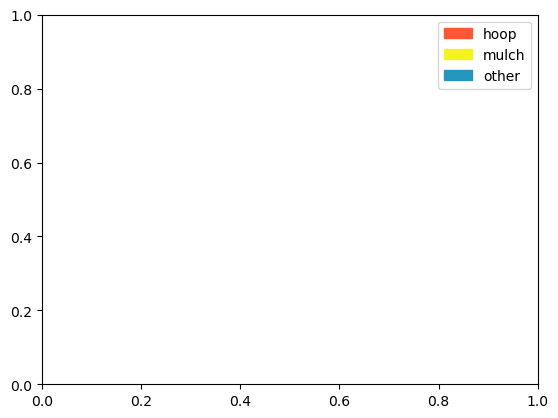

In [45]:
# print out the map legend
# colors = ['#FF5733', '#F4F31D', '#2596be', '#333333']
# labels = ['hoop', 'mulch', 'other', 'blackmulch']
colors = ['#FF5733', '#F4F31D', '#2596be']
labels = ['hoop', 'mulch', 'other']

# Create a legend with the colors and labels
patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
plt.legend(patches, labels)

plt.show()

### Probability classifier

In [46]:
trained_prob_RF = ee.Classifier.smileRandomForest(50).setOutputMode('MULTIPROBABILITY').train(training, 'class', bands_tr)

classified_multi = oneday.classify(trained_prob_RF).updateMask(crops)

# Extract the probabilities for each cover type
probabilities = classified_multi.arrayFlatten([['hoop', 'mulch', 'other']])

m = geemap.Map()
# m.add_basemap('HYBRID')
m.addLayer(oneday_original, rgbVis, 'Full Sentinel: ' + date)
m.addLayer(oneday, rgbVis, 'Cloudless Sentinel: ' + date, False)
m.addLayer(classified_multi, {}, 'Raw output', False)
m.addLayer(probabilities, {}, 'Classified Probabilities')
m.centerObject(ca, 6)
m

Map(center=[37.152434104671315, -119.52655155150876], controls=(WidgetControl(options=['position', 'transparen…

## 7. Time series of plastic probability 

#### Set date range

In [47]:
# would be great to write code that takes a date and immediately add x days to it for some number of dates
# then you could just input the first date and the number of dates you want to sample
# and it would automatically generate the list of dates for you
first_date = '2022-05-24'
first_date = datetime.strptime(first_date, '%Y-%m-%d')
days_bt = 35 # multiples of 5 ensure the images will land in the same place in CA
num_dates = 15

dates = []
for i in range(num_dates):
    new_date = first_date + timedelta(days=i*days_bt)
    dates.append(new_date.strftime('%Y-%m-%d'))

dates

# six days spread out through the year, I think they will all cover the watsonville area
# best to have these separated by 5 days if you'd like to stay in one area
# dates = ['2021-01-04', '2021-03-15', '2021-05-24', '2021-08-02', '2021-10-11', '2021-12-20']

['2022-05-24',
 '2022-06-28',
 '2022-08-02',
 '2022-09-06',
 '2022-10-11',
 '2022-11-15',
 '2022-12-20',
 '2023-01-24',
 '2023-02-28',
 '2023-04-04',
 '2023-05-09',
 '2023-06-13',
 '2023-07-18',
 '2023-08-22',
 '2023-09-26']

#### Create time series for those dates with sentinel and ET

In [48]:
timeseries = ee.ImageCollection([])

for date in dates:
    nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
    oneday = processedCollection.filterDate(date, nextday).median()
    oneday_original = s2.filterDate(date, nextday).median()

    # get ET data for the month of that date
    et_date = ee.Date(ee.Date(date).format('yyyy-MM-01')) #convert to first of month for ET data
    et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')

    # add ET band to sentinel-2 image
    oneday = oneday.addBands(et_img).set('date', date)

    # add each image to the collection
    timeseries = timeseries.merge(ee.ImageCollection([oneday]))


#### Classify probability for each class across each image

In [49]:
# classify each image in the timeseries collection
def classify_image(image):
    date = image.get('date')
    classified_multi = image.classify(trained_prob_RF).updateMask(crops)
    probabilities = classified_multi.arrayFlatten([['hoop', 'mulch', 'other']])
    return probabilities.set('date', date)

classified_timeseries = timeseries.map(classify_image)

# display(classified_timeseries)


#### *Display the result and draw a geometry for the time series analysis

In [50]:
# Map = geemap.Map()
# Map.add_basemap('HYBRID')
# Map.addLayer(oneday, rgbVis, 'Cloudless Sentinel: ' + date) #adds last image from the for loop
# Map.addLayer(classified_timeseries, {'min': 0, 'max': 1.0}, 'Classified Probabilities')
# Map.centerObject(cruz, 10)
# Map

In [51]:
# If you need, export the region to your assets
# region = ee.Feature(Map.draw_last_feature)
# task = ee.batch.Export.table.toAsset(
#     collection=ee.FeatureCollection(region),
#     description='region_export',
#     assetId='projects/ee-annalisertaylor/assets/TNC/agplastics/sample_region'
# )
# task.start()

#### Create df with each class probability across an image collection for a region

In [52]:
# # convert the last drawn feature from map above to an ee.Feature
# region = ee.Feature(Map.draw_last_feature)

# # can also import a good example feature from assets
# # region = ee.FeatureCollection('projects/ee-annalisertaylor/assets/TNC/agplastics/sample_region').first()

# def RR_all_features(image):
#     # this is a dictionary
#     means_dict = image.reduceRegion(ee.Reducer.mean(), region.geometry(), 10)
#     # add the image date to the ee.Dictionary
#     means_dict = means_dict.set('date', image.get('date'))
#     feat = ee.Feature(None, means_dict)
#     return feat

# result = ee.FeatureCollection(classified_timeseries.map(RR_all_features))

# df = geemap.ee_to_df(result)
# df
# # print out number of null values in each column
# # df.isnull().sum()

#### Chart the time series

In [53]:
# # just a line chart
# # df.plot(x='date', y=['hoop', 'mulch', 'other'], kind='line', color=['#FF5733', '#F4F31D', '#2596be'])

# # line chart layered with points for clarity
# plt.plot(df['date'], df['other'], '-o', color='#2596be', label='other')
# plt.plot(df['date'], df['hoop'], '-o', color='#FF5733', label='hoop')
# plt.plot(df['date'], df['mulch'], '-o', color='#F4F31D', label='mulch')
# plt.legend()
# plt.xticks(rotation=45, ha='right')
# plt.show()

##### can test if the region updated appropriately

In [54]:
# m = geemap.Map()
# m.add_basemap('HYBRID')
# m.addLayer(classified_timeseries.first(), {}, 'Classified Probabilities')
# m.addLayer(region, {}, 'Region')
# m.centerObject(region, 13)
# m

## 8. Classify all images in a year across CA/one county

In [55]:
# grab all sentinel images in a year (cloud filtered)
# set the water year and county of interest
wy = 2023
county = cruz # ventura, mendo, cruz, santabarbara

# get text name of county
county_name = county.first().get('NAME').getInfo().replace(" ", "")

# create dates
stdate = f'{wy-1}-10-01'
endate = f'{wy}-10-01' # end date is exclusive

# ~24 images per day across CA, ~169 images to cover CA over 5 days
# ~256 images per year in santa cruz county
sentinel_ts = processedCollection.filterDate(stdate, endate).filterBounds(county)
print(f'Plastic classification for {county_name} County in water year {wy}')
print('Number of images: ', sentinel_ts.size().getInfo())

# then add corresponding ET data for each month (map over collection)
def add_ET(image):
    image_sts = image.get('system:time_start')
    date = image.date()
    et_date = ee.Date(ee.Date(date).format('yyyy-MM-01')) #convert to first of month for ET data
    et_img = et.filterDate(et_date, et_date.advance(1, 'month')).median().rename('ET')
    return image.addBands(et_img).set('system:time_start', image_sts)

sentinel_ts_ET = sentinel_ts.map(add_ET)

# then classify each image (map over collection)
def classify_image_2(image):
    image_sts = image.get('system:time_start') # enables filterDate functionality
    date = image.get('date')
    classified_multi = image.classify(trained_prob_RF).updateMask(crops)
    probabilities = classified_multi.arrayFlatten([['hoop', 'mulch', 'other']])
    return probabilities.set('date', date).set('system:time_start', image_sts)

classified_timeseries = sentinel_ts_ET.map(classify_image_2)

Plastic classification for SantaCruz County in water year 2023
Number of images:  246


#### Get top percentile value

In [56]:
# create a mosaic for one day and add to map for testing

# either by testing a date
# date = '2022-01-20'
# nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
# classified = classified_timeseries.filterDate(date, nextday).median()

# or taking the entire collection
# count = sentinel_ts.count()
classified = classified_timeseries.reduce(ee.Reducer.percentile([95])).select(['hoop_p95', 'mulch_p95'])
# classifiedmask = classified.gt(0.75)
sentinel_image = sentinel_ts.median()

# add to map
# ca_outline = ee.FeatureCollection(ca).style(fillColor='00000000')
# m = geemap.Map()
# m.add_basemap('HYBRID')
# m.addLayer(sentinel_image, rgbVis, 'Cloudless Sentinel', False)
# m.addLayer(classified, {}, 'Classified Probabilities', False)
# m.addLayer(count, {'min': 0, 'max': 75}, 'Number of Images')
# m.addLayer(ca_outline, {}, 'California')
# m.centerObject(ca, 6)
# m

#### Comparing the two bands to get integrated raster
i.e. if a pixel is classified as mulch and hoop, use difference from threshold to determine which class it is

In [57]:
def integrate_classes(image):
    # Define my thresholds for each band
    bh_th = 0.6
    bm_th = 0.5

    # Define the two bands you want to compare
    # input image is classified, has a hoop_p95 and mulch_p95 band
    bh = image.select('hoop_p95')
    bm = image.select('mulch_p95')

    # I need above or below threshold for each
    # bh_gt = bh.gte(bh_th).rename('bh_gt') # if bh is gte threshold, bh_gt = 1
    # bm_gt = bm.gte(bm_th).rename('bm_gt')

    # difference from threshold for each
    bh_diff = bh.subtract(bh_th).rename('bh_diff')
    bm_diff = bm.subtract(bm_th).rename('bm_diff')

    class_band = image.expression(
        # "bh_gt >= 0 ? 1 : (bm_gt >= 0 ? 2 : 0)", # super simple version
        # if bh if gte threshold, class = 1 (hoop)
        # if bm if gte threshold, class = 2 (mulch)
        # if bh and bm are both under threshold, class = 0 (other)
        # this is the more complex version that takes into account the difference from the threshold
        # if bh_diff = bm_diff, classify it as hoop (1)
        "(bh_diff >= 0 && (bm_diff < 0 || bh_diff >= bm_diff)) ? 1 : ((bm_diff >= 0 && (bh_diff < 0 || bm_diff > bh_diff)) ? 2 : 0)",
        {
            # 'bh_gt': bh_gt, # these are 0 or 1
            # 'bm_gt': bm_gt, # 0 or 1
            'bh_diff': bh_diff,
            'bm_diff': bm_diff
        }
    ).rename('class')
    return image.addBands(class_band)


classified_integrated = integrate_classes(classified)

classes = classified_integrated.select('class').updateMask(crops).clip(county)


# Add the results to the map
# m = geemap.Map()
# m.addLayer(classified, {}, 'Classified Probabilities', False)
# m.addLayer(classes, {'min': 0, 'max': 2, 'palette': ['blue', 'red', 'yellow']}, 'Final Classes')
# m.centerObject(ventura, 6)
# m

#### Export the masked, unmasked probability image OR integrated image

In [ ]:
# export integrated raster to asset
# export_task = ee.batch.Export.image.toAsset(
#     image=classes,
#     description=f'classes_image_{county_name}_{wy}',
#     assetId=f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county_name}Co_WY{wy}_int_new',
#     region=county.geometry(),
#     scale=10,
#     maxPixels=1e13
# )
# export_task.start()

# export integrated raster to drive
export_task = ee.batch.Export.image.toDrive(
    image=classes,
    description=f'classes_image_{county_name}_{wy}',
    fileNamePrefix=f'PlasticClass_{county_name}Co_WY{wy}_int_new',
    folder='EarthEngine',
    #region=county.geometry(),
    scale=10,
    maxPixels=1e13
)
# export_task.start()

### 8.5 Thresholding - extract WY values to validation points


#### split into EE water years

In [59]:
# # set which water years you need
# wys = [2019, 2020, 2021, 2022, 2023]

# # initialize an empty image
# wys_all = ee.Image()

# for wy in wys:
#     stdate = f'{wy-1}-10-01'
#     endate = f'{wy}-09-30'
#     mulch_label = f'mulch_wy{wy}'
#     hoop_label = f'hoop_wy{wy}'
#     wy_images = classified_timeseries.filterDate(stdate, endate).select(['hoop', 'mulch', 'other'])
#     wy_bands = wy_images.reduce(ee.Reducer.percentile([95])).select(['hoop_p95', 'mulch_p95']).rename([hoop_label, mulch_label])
#     wys_all = wys_all.addBands(wy_bands)
# wys_all

In [60]:
# # gonna try exporting it to an asset
# export_task = ee.batch.Export.image.toAsset(
#     image=wys_all,
#     description='wats_wys',
#     assetId='projects/ee-tnc-annietaylor/assets/agplastics/SantaCruzCo_WYs_95p',
#     region=cruz.geometry(), #CHANGE THIS
#     scale=10,
#     maxPixels=1e13
# )
# export_task.start()

#### Export band values to training points using EE fn

In [61]:
# # sample hoop/mulch probability for each WY to all validation points
# wats_fcpts = geemap.df_to_ee(watsonville, latitude='Latitude', longitude='Longitude')
# wys_all = ee.Image('projects/ee-tnc-annietaylor/assets/agplastics/SantaCruzCo_WYs_95p')

# sampled_points = wys_all.sampleRegions(
#     collection=wats_fcpts,
#     scale=200 # ideally 10m
# )

# # Convert the sampled points to df
# sampled_points_df = geemap.ee_to_df(sampled_points)

# # Display the DataFrame
# print(sampled_points_df)


#### Export band values to training points in geopandas

In [62]:
# Loop through all rasters and sample to the points for that region
# watsonville:
# df = watsonville
# wys = [2020, 2021, 2022, 2023]
# rasters = [
#     'Plastic_SantaCruzCo_95p_WY2020.tif',
#     'Plastic_SantaCruzCo_95p_WY2021.tif',
#     'PlasticClass_SantaCruzCo_95p_WY2022.tif',
#     'Plastic_SantaCruzCo_95p_WY2023.tif'
# ]

# df = oxnard
# wys = [2019, 2020, 2021, 2022, 2023]
# rasters = [
#     'Plastic_VenturaCo_95p_WY2019.tif',
#     'Plastic_VenturaCo_95p_WY2020.tif',
#     'Plastic_VenturaCo_95p_WY2021.tif',
#     'PlasticClass_venturaCo_95p_WY2022.tif',
#     'Plastic_VenturaCo_95p_WY2023.tif'
# ]

df = santamaria
wys = [2021, 2022, 2023]
rasters = [
    'Plastic_SBCo_95p_WY2021.tif',
    'PlasticClass_santabarbaraCo_95p_WY2022.tif',
    'Plastic_SBCo_95p_WY2023.tif'
]

for wy, raster in zip(wys, rasters):
    # src = rasterio.open(f'N:\OCEANS_Program\Plastics\Agricultural_Plastics\AgPlastics_Pro\EE_uploads_exports\Watsonville\\{raster}')
    # src = rasterio.open(f'N:\OCEANS_Program\Plastics\Agricultural_Plastics\AgPlastics_Pro\EE_uploads_exports\Oxnard\\{raster}')
    src = rasterio.open(f'N:\OCEANS_Program\Plastics\Agricultural_Plastics\AgPlastics_Pro\EE_uploads_exports\SantaMaria\\{raster}')
    coord_list = [(x, y) for x, y in zip(df["Longitude"], df["Latitude"])]
    df[[f'hoop_wy{wy}', f'mulch_wy{wy}']] = [a for a in src.sample(coord_list)]

df.head()

Location  Type        Date   Latitude   Longitude  class  hoop_wy2021  \
0  Santa Maria  hoop  2022-08-26  34.933197 -120.480369      0     0.967840   
1  Santa Maria  hoop  2022-08-26  34.934205 -120.481699      0     0.975545   
2  Santa Maria  hoop  2022-08-26  34.934072 -120.480529      0     0.982159   
3  Santa Maria  hoop  2022-08-26  34.933884 -120.481199      0     0.975896   
4  Santa Maria  hoop  2022-08-26  34.933903 -120.479949      0     0.981575   

   mulch_wy2021  hoop_wy2022  mulch_wy2022  hoop_wy2023  mulch_wy2023  
0      0.112994     0.967995      0.241791     0.981575      0.188247  
1      0.343947     0.919773      0.391863     0.907781      0.293251  
2      0.152778     0.979510      0.197627     0.979378      0.157085  
3      0.214452     0.980343      0.184116     0.980993      0.166488  
4      0.137228     0.976630      0.187711     0.980993      0.137705

#### Assign hoop & mulch fields to WY value based on training data date

In [63]:
# First add a col with water year to the df
# make a new col that is in datetime format
df['pDate'] = pd.to_datetime(df['Date'])

def add_WY(row):
    if row['pDate'].month >= 10:
        return row['pDate'].year + 1
    else:
        return row['pDate'].year

df['WY'] = df.apply(add_WY, axis=1)

# print(df['WY'].unique())

# exclude 2018 since we don't have images for it
# this will be different for each region
# df = df[df['WY'] > 2018] # need for watsonville
# df = df[df['WY'] < 2024] # need for oxnard
df = df[df['WY'] > 2020] # need for santamaria

# set the hoop field to be the corresponding hoop_wy{wy} value based on the WY field
df['hoop'] = df.apply(lambda x: x[f'hoop_wy{x["WY"]}'], axis=1)
df['mulch'] = df.apply(lambda x: x[f'mulch_wy{x["WY"]}'], axis=1)

df.head()
# df[df['WY'] == 2021].head(100)

Location  Type        Date   Latitude   Longitude  class  hoop_wy2021  \
0  Santa Maria  hoop  2022-08-26  34.933197 -120.480369      0     0.967840   
1  Santa Maria  hoop  2022-08-26  34.934205 -120.481699      0     0.975545   
2  Santa Maria  hoop  2022-08-26  34.934072 -120.480529      0     0.982159   
3  Santa Maria  hoop  2022-08-26  34.933884 -120.481199      0     0.975896   
4  Santa Maria  hoop  2022-08-26  34.933903 -120.479949      0     0.981575   

   mulch_wy2021  hoop_wy2022  mulch_wy2022  hoop_wy2023  mulch_wy2023  \
0      0.112994     0.967995      0.241791     0.981575      0.188247   
1      0.343947     0.919773      0.391863     0.907781      0.293251   
2      0.152778     0.979510      0.197627     0.979378      0.157085   
3      0.214452     0.980343      0.184116     0.980993      0.166488   
4      0.137228     0.976630      0.187711     0.980993      0.137705   

       pDate    WY      hoop     mulch  
0 2022-08-26  2022  0.967995  0.241791  
1 2022-08-26  2022  0.919773  0.391863  
2 2022-08-26  2022  0.979510  0.197627  
3 2022-08-26  2022  0.980343  0.184116  
4 2022-08-26  2022  0.976630  0.187711

#### Save to csv for easy import into threshold_determination script

In [64]:
# csv_name = train_path + 'Watsonville_val_BM_P95.csv'
# csv_name = train_path + 'Oxnard_all_P95.csv'
# csv_name = train_path + 'SantaMaria_val_o_P95.csv'
# df.to_csv(csv_name)
# when importing, drop 0 and null values

## 9. Area Calculations

### Reduce area to counties - integrated raster

In [66]:
county = cruz
wys = [2019, 2020, 2021, 2022, 2023]

county_name = county.first().get('NAME').getInfo().replace(" ", "")

# Create a pixel area image. Pixel values are square meters based on a given CRS and scale (or CRS transform).
pixel_area = ee.Image.pixelArea()
# The default projection is WGS84 with 1-degree scale.
# display('Pixel area default projection', pixel_area.projection())

df_county_ts = []

for wy in wys:
    # import asset
    ras = ee.Image(f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county_name}Co_WY{wy}_int')
    
    # reproject the raster (doesn't appear necessary, results identical) 
    ras = ras.reproject(crs='EPSG:3310', scale=10)

    hoop = ras.select('class').eq(1)
    mulch = ras.select('class').eq(2) # TODO print these to map to double check

    hoop_area = pixel_area.updateMask(hoop)
    mulch_area = pixel_area.updateMask(mulch)

    hoop_area_calc = hoop_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=county.geometry(),
        crs=ee.Projection('EPSG:3310'),
        scale=10,
        # crsTransform=ras2022.projection().getInfo()['transform'],
        maxPixels=1e8,
    )

    mulch_area_calc = mulch_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=county.geometry(),
        crs=ee.Projection('EPSG:3310'),
        scale=10,
        # crsTransform=ras2022.projection().getInfo()['transform'],
        maxPixels=1e8,
    )

    hoop_m2 = hoop_area_calc.getNumber('area').getInfo()
    mulch_m2 = mulch_area_calc.getNumber('area').getInfo()

    # save these numbers to a dataframe
    data = {
        'Year': [wy],
        'County': [county_name],
        'Hoop_m2': [hoop_m2],
        'Hoop_acres': [(hoop_m2/4046.8564224)], # to convert m2 to acres
        'Mulch_m2': [mulch_m2],
        'Mulch_acres': [(mulch_m2/4046.8564224)]
    }
    df_county_ts.append(pd.DataFrame(data))

df_area = pd.concat(df_county_ts)
display(df_area)

# display(f'Area of plastic mulch in {county_name} County in 2022 is {mulch_sqmeters_22.getInfo():.2f} m2 or {mulch_acres_22.getInfo():.2f} acres')
# display(f'Area of hoop houses in {county_name} County in 2022 is {hoop_sqmeters_22.getInfo():.2f} m2 or {hoop_acres_22.getInfo():.2f} acres')
# display(f'Area of {plastic_type} in 2023  m2: {square_meters_23.getInfo()}, acres: {acres_23.getInfo()}')

Year     County       Hoop_m2   Hoop_acres      Mulch_m2  Mulch_acres
0  2019  SantaCruz  1.777853e+07  4393.169517  2.073380e+07  5123.433849
0  2020  SantaCruz  1.375595e+07  3399.168933  1.987150e+07  4910.355169
0  2021  SantaCruz  1.414766e+07  3495.962146  1.792406e+07  4429.132653
0  2022  SantaCruz  1.224968e+07  3026.961268  1.872361e+07  4626.704259
0  2023  SantaCruz  1.176698e+07  2907.683016  2.402792e+07  5937.427756

### Calculate acreage as percent of ag lands

In [67]:
all_ag = ee.Image('projects/ee-annalisertaylor/assets/TNC/agplastics/dwr_allyears')

# clip to county
county_ag = all_ag.clip(county)

# reproject the raster
county_ag = county_ag.reproject(crs='EPSG:3310', scale=10)

# mask pixel area image to ag lands
ag_area = pixel_area.updateMask(county_ag)

ag_area_calc = ag_area.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=county.geometry(),
    crs=ee.Projection('EPSG:3310'),
    scale=10,
    # crsTransform=ras2022.projection().getInfo()['transform'],
    maxPixels=1e8,
)

# extract area and add to a df
ag_area_m2 = ag_area_calc.getNumber('area').getInfo()

results = {
    'County': county_name,
    'Ag_m2': ag_area_m2,
    'Ag_acres': (ag_area_m2/4046.8564224)
}

display(results)

# add a column to df_area standardized by ag land area in that county
df_area['Hoop_acres_percent'] = df_area['Hoop_acres'] / results['Ag_acres']
df_area['Mulch_acres_percent'] = df_area['Mulch_acres'] / results['Ag_acres']
df_area


{'County': 'SantaCruz',
 'Ag_m2': 74373534.11764704,
 'Ag_acres': 18378.100519202406}

Year     County       Hoop_m2   Hoop_acres      Mulch_m2  Mulch_acres  \
0  2019  SantaCruz  1.777853e+07  4393.169517  2.073380e+07  5123.433849   
0  2020  SantaCruz  1.375595e+07  3399.168933  1.987150e+07  4910.355169   
0  2021  SantaCruz  1.414766e+07  3495.962146  1.792406e+07  4429.132653   
0  2022  SantaCruz  1.224968e+07  3026.961268  1.872361e+07  4626.704259   
0  2023  SantaCruz  1.176698e+07  2907.683016  2.402792e+07  5937.427756   

   Hoop_acres_percent  Mulch_acres_percent  
0            0.239044             0.278779  
0            0.184958             0.267185  
0            0.190224             0.241001  
0            0.164705             0.251751  
0            0.158215             0.323071

In [ ]:
# save to a csv for import into a stacked chart
csv_name = f'N:\OCEANS_Program\Plastics\Agricultural_Plastics\Area_by_County\plasticAreaOverTime_{county_name}County.csv'
# df_area.to_csv(csv_name, index=False)


### Plot plastic acreage over time - one county

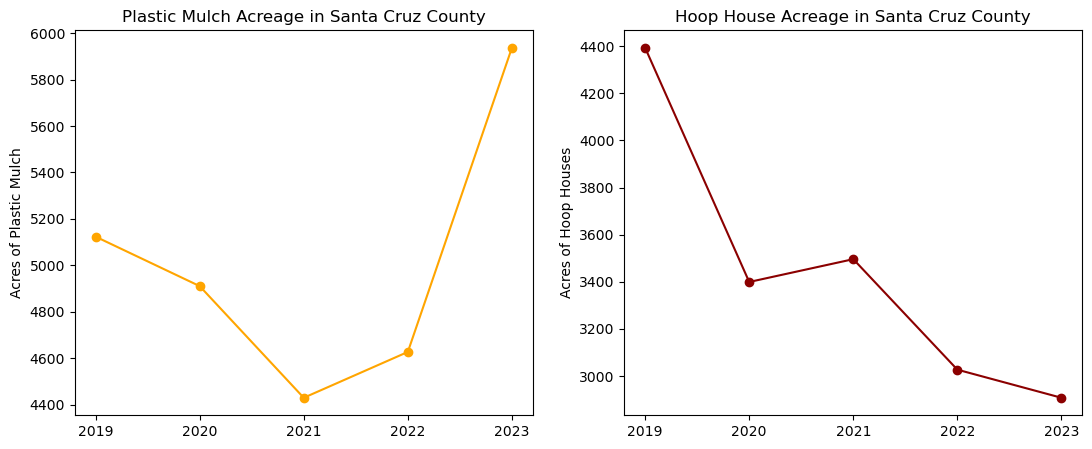

In [69]:
county_name = county_name.replace("Santa", "Santa ")
# Plot the change in mulch_acres and hoop_acres over Year side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Plot for Mulch Acres
ax1.plot(df_area['Year'], df_area['Mulch_acres'], marker='o', linestyle='-', color='orange')
ax1.set_ylabel('Acres of Plastic Mulch')
ax1.set_title(f'Plastic Mulch Acreage in {county_name} County')
ax1.set_xticks(df_area['Year'])  # Set x-axis ticks to be the integer values of the year

# Plot for Hoop Acres
ax2.plot(df_area['Year'], df_area['Hoop_acres'], marker='o', linestyle='-', color='darkred')
ax2.set_ylabel('Acres of Hoop Houses')
ax2.set_title(f'Hoop House Acreage in {county_name} County')
ax2.set_xticks(df_area['Year'])  # Set x-axis ticks to be the integer values of the year

plt.show()

### Plot plastic percent of acreage over time

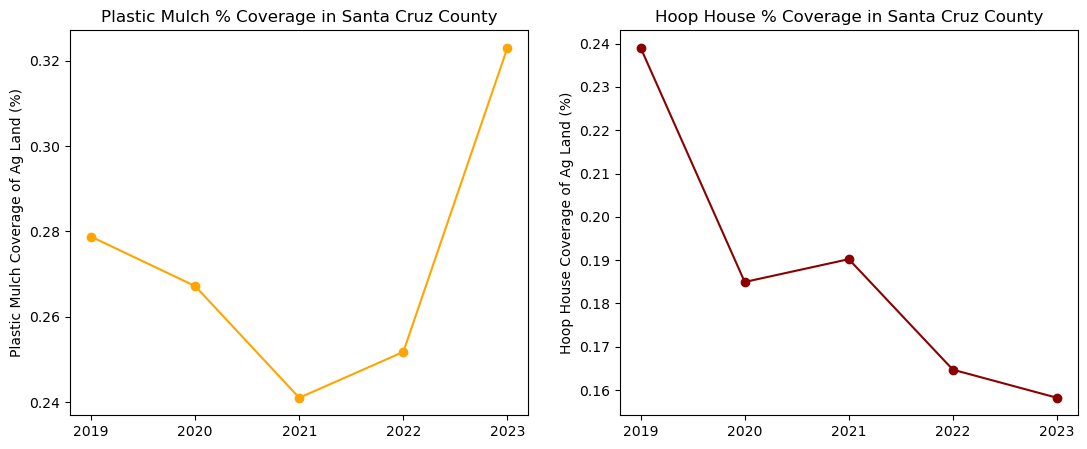

In [70]:
# Plot the change in mulch_acres_percent and hoop_acres_percent over year side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Plot for Mulch Acres
ax1.plot(df_area['Year'], df_area['Mulch_acres_percent'], marker='o', linestyle='-', color='orange')
ax1.set_ylabel('Plastic Mulch Coverage of Ag Land (%)')
ax1.set_title(f'Plastic Mulch % Coverage in {county_name} County')
ax1.set_xticks(df_area['Year'])  # Set x-axis ticks to be the integer values of the year

# Plot for Hoop Acres
ax2.plot(df_area['Year'], df_area['Hoop_acres_percent'], marker='o', linestyle='-', color='darkred')
ax2.set_ylabel('Hoop House Coverage of Ag Land (%)')
ax2.set_title(f'Hoop House % Coverage in {county_name} County')
ax2.set_xticks(df_area['Year'])  

plt.show()

#### Import csvs with area calculations

In [79]:
# import all three csvs and combine into one df
df_sb = pd.read_csv('N:\OCEANS_Program\Plastics\Agricultural_Plastics\Area_by_County\plasticAreaOverTime_SantaBarbaraCounty.csv')
df_vt = pd.read_csv('N:\OCEANS_Program\Plastics\Agricultural_Plastics\Area_by_County\plasticAreaOverTime_VenturaCounty.csv')
df_sc = pd.read_csv('N:\OCEANS_Program\Plastics\Agricultural_Plastics\Area_by_County\plasticAreaOverTime_SantaCruzCounty.csv')

df_all = pd.concat([df_sb, df_vt, df_sc])
df_all['Hoop_acres_percent'] *= 100 #adjusting this for plotting
df_all['Mulch_acres_percent'] *= 100
df_all['County_Name'] = df_all['County'].str.replace('Santa', 'Santa ')

#### Stacked area charts - counties side by side

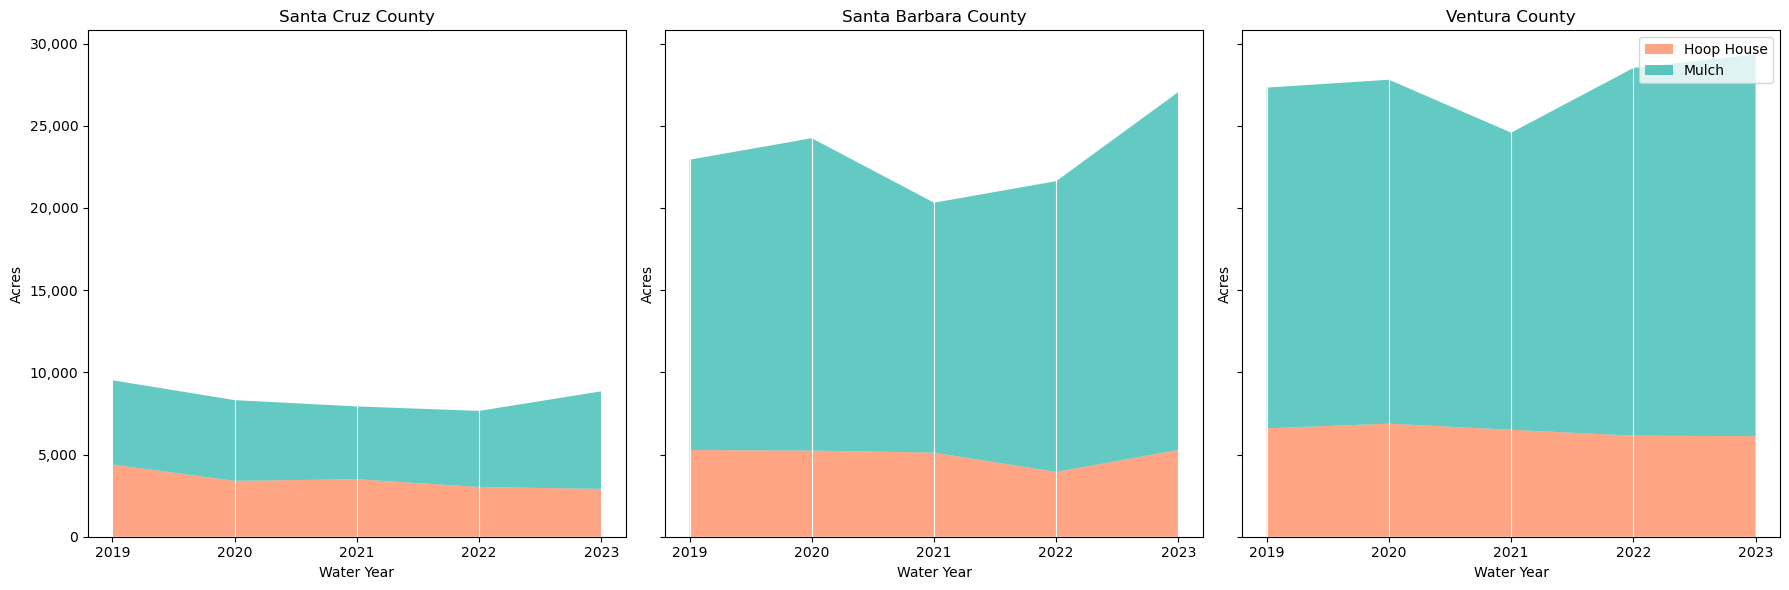

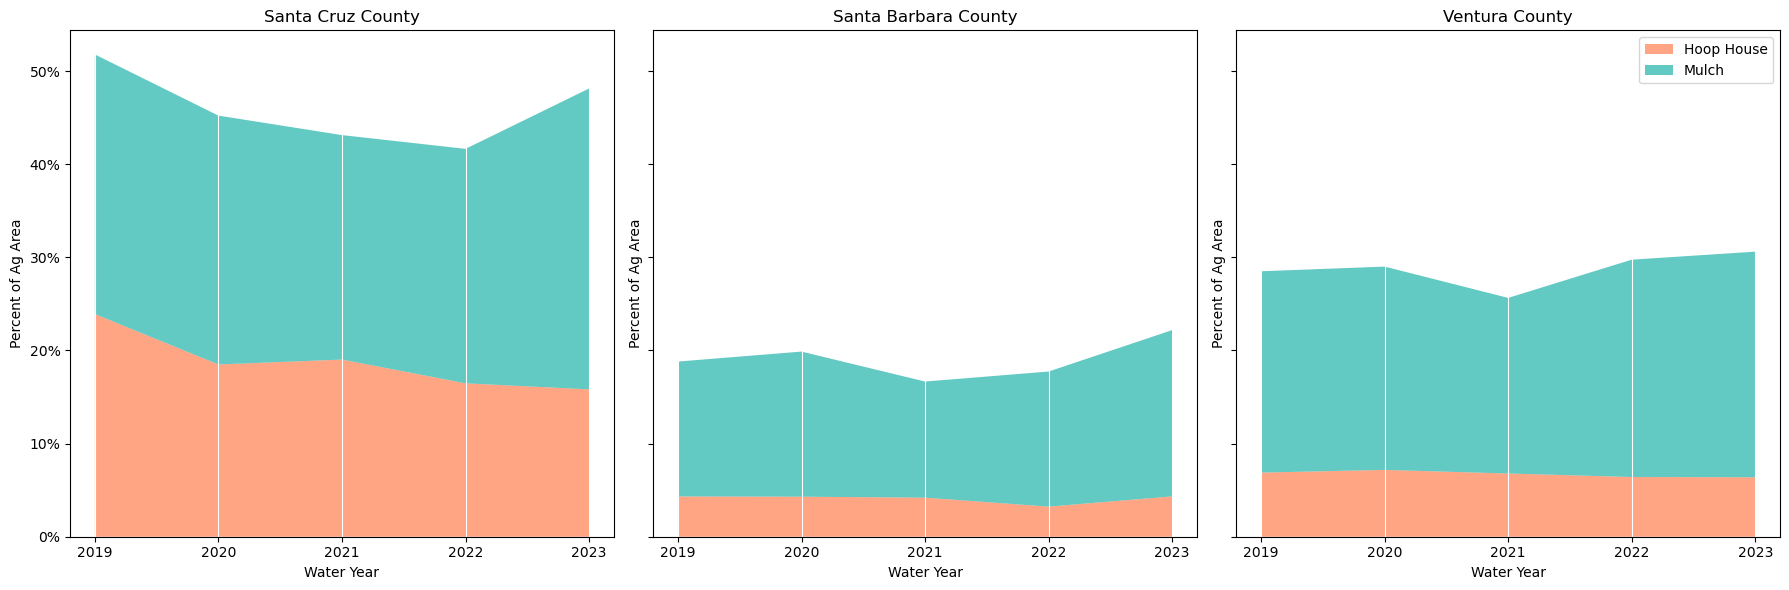

In [80]:
# iterate through the three counties' dataframes to plot them
df_list = [df_sc, df_sb, df_vt] # in order N to S

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, df in zip(axes, df_list):
    location = df['County'].unique()[0].replace('Santa', 'Santa ')
    ax.stackplot(df['Year'], df['Hoop_acres'], df['Mulch_acres'], labels=['Hoop House', 'Mulch'], colors=['coral', 'lightseagreen'], alpha=0.7)
    ax.set_title(f'{location} County')
    ax.set_xlabel('Water Year')
    ax.set_xticks(df['Year'])
    ax.grid(axis='x', linestyle='-', color='white')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.set_ylabel('Acres')
axes[2].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, df in zip(axes, df_list):
    df['Hoop_acres_percent'] *= 100 #TODO just convert this at the creation stage, not here
    df['Mulch_acres_percent'] *= 100
    location = df['County'].unique()[0].replace('Santa', 'Santa ')
    ax.stackplot(df['Year'], df['Hoop_acres_percent'], df['Mulch_acres_percent'], labels=['Hoop House', 'Mulch'], colors=['coral', 'lightseagreen'], alpha=0.7)
    ax.set_title(f'{location} County')
    ax.set_xlabel('Water Year')
    ax.set_xticks(df['Year'])
    ax.grid(axis='x', linestyle='-', color='white')
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    ax.set_ylabel('Percent of Ag Area')
axes[2].legend()

plt.tight_layout()
plt.show()

#### Stacked area charts - mulch and hoop split

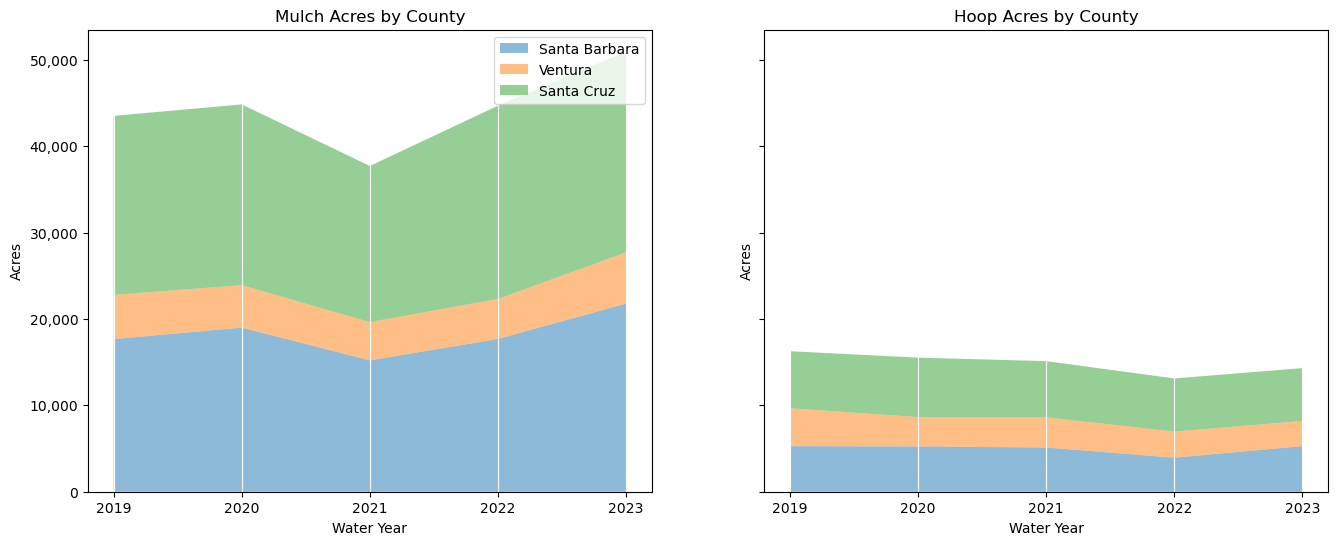

In [81]:
# create a stacked area chart with all three counties together using df_all
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Add space after 'Santa' in the County column for display

ax1, ax2 = axes
# Create the stacked area chart for Hoop Acres
ax1.stackplot(df_all['Year'].unique(), df_all.pivot(index='Year', columns='County_Name', values='Mulch_acres').fillna(0).T, labels=df_all['County_Name'].unique(), alpha=0.5)
ax1.set_title('Mulch Acres by County')
ax1.set_xlabel('Water Year')
ax1.set_ylabel('Acres')
ax1.set_xticks(df['Year'])
ax1.grid(axis='x', linestyle='-', color='white')
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax1.legend()

# Create the stacked area chart for Mulch Acres
ax2.stackplot(df_all['Year'].unique(), df_all.pivot(index='Year', columns='County_Name', values='Hoop_acres').fillna(0).T, labels=df_all['County_Name'].unique(), alpha=0.5)
ax2.set_title('Hoop Acres by County')
ax2.set_xlabel('Water Year')
ax2.set_ylabel('Acres')
ax2.set_xticks(df['Year'])
ax2.grid(axis='x', linestyle='-', color='white')
ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#### Stacked area chart - all acres combined

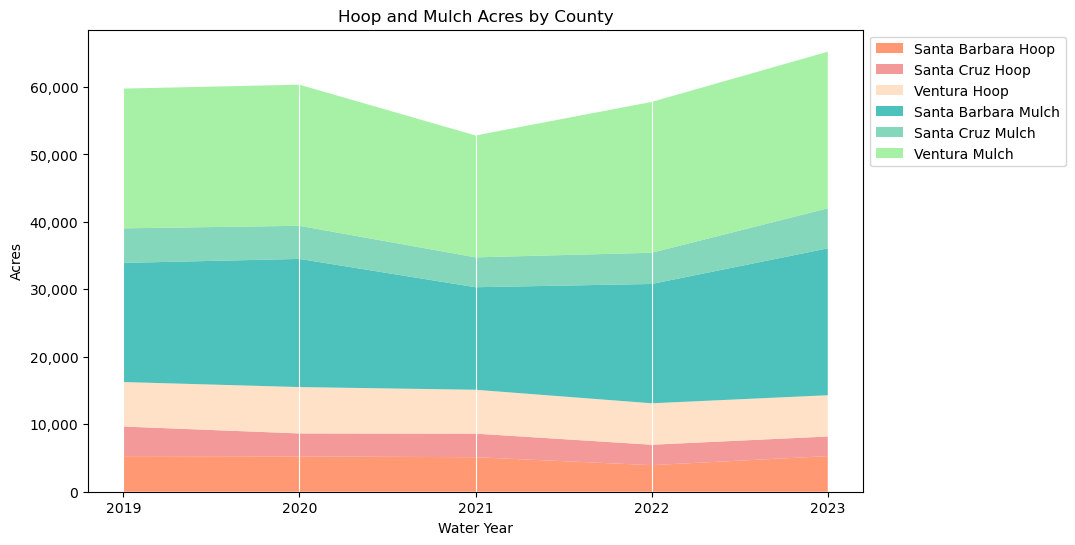

In [82]:
# Create a stacked area chart with all three counties together using df_all
fig, ax = plt.subplots(figsize=(10, 6))

# Pivot the dataframe to get the data in the right format for stacking
pivot_df = df_all.pivot(index='Year', columns='County_Name', values=['Hoop_acres', 'Mulch_acres'])

color_map = ["coral", "lightcoral", "peachpuff", "lightseagreen", "mediumaquamarine", "lightgreen"]


# Plot the stacked area chart for Hoop and Mulch Acres
ax.stackplot(pivot_df.index, 
             pivot_df['Hoop_acres'].T, 
             pivot_df['Mulch_acres'].T, 
             labels=[f'{county} Hoop' for county in pivot_df['Hoop_acres'].columns] + [f'{county} Mulch' for county in pivot_df['Mulch_acres'].columns], 
             alpha=0.8,
             colors=color_map)

# Set the title and labels
ax.set_title('Hoop and Mulch Acres by County')
ax.set_xlabel('Water Year')
ax.set_ylabel('Acres')
ax.set_xticks(df_all['Year'].unique())
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(axis='x', linestyle='-', color='white')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# Show the plot
plt.show()

### Add final classifications to map

In [78]:
wy = 2023
county_name = 'SantaBarbara'

ras = ee.Image(f'projects/ee-tnc-annietaylor/assets/agplastics/PlasticClass_{county_name}Co_WY{wy}_int')

# test my masking as well TODO from above


# add to map
m = geemap.Map()
m.add_basemap('SATELLITE')
m.addLayer(ras.select('class'), {'min': 0, 'max': 2, 'palette': ['blue', 'red', 'yellow']}, 'Final Classes')
m.centerObject(ca, 6)
# m

##### Archive

In [123]:
# convert watsonville df to a geopandas df
# gdf = gpd.GeoDataFrame(watsonville, geometry=gpd.points_from_xy(watsonville.Longitude, watsonville.Latitude))
# gdf = gdf.set_crs('EPSG:4326')

# plot the points
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf.plot(ax=ax, color='red', markersize=10)
# plt.show()

# src = rasterio.open('N:\OCEANS_Program\Plastics\Agricultural_Plastics\AgPlastics_Pro\EE_uploads_exports\Watsonville\Plastic_SantaCruzCo_95p_WY2023.tif')

# # plot points with raster
# fig, ax = plt.subplots()
# # transform rasterio plot to real world coords
# extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
# extent = [-121.9, src.bounds[2], src.bounds[1], 37.0]
# ax = rasterio.plot.show(mulch, extent=extent, ax=ax, cmap="viridis")
# gdf.plot(ax=ax, color='red', markersize=0.5)
# # print(extent)



In [ ]:
# old acreage calculation
# plastic_type = 'mulch_p95'
# county = ventura

# # I've shared these from my personal EE account
# plastic_2019_95p = ee.Image('projects/ee-annalisertaylor/assets/TNC/agplastics/PlasticClass_VenturaCo_95p_2019_mask75')
# plastic_2023_95p = ee.Image('projects/ee-annalisertaylor/assets/TNC/agplastics/PlasticClass_VenturaCo_95p_2023_mask75')

# # Create a pixel area image. Pixel values are square meters based on
# # a given CRS and scale (or CRS transform).
# pixel_area = ee.Image.pixelArea()

# # The default projection is WGS84 with 1-degree scale.
# # display('Pixel area default projection', pixel_area.projection())

# plastic_2019 = plastic_2019_95p.select(plastic_type).gt(0)
# plastic_2023 = plastic_2023_95p.select(plastic_type).gt(0)

# # Apply the hoop or mulch classified area mask to the pixel area image.
# plastic_area_2019 = pixel_area.updateMask(plastic_2019)
# plastic_area_2023 = pixel_area.updateMask(plastic_2023)

# area_2019 = plastic_area_2019.reduceRegion(
#     reducer=ee.Reducer.sum(),
#     geometry=county.geometry(),
#     crs=ee.Projection('EPSG:3310'),
#     # crs=hoop.projection(),
#     scale=10,
#     maxPixels=1e8,
# )

# area_2023 = plastic_area_2023.reduceRegion(
#     reducer=ee.Reducer.sum(),
#     geometry=county.geometry(),
#     crs=ee.Projection('EPSG:3310'),
#     # crs=hoop.projection(),
#     scale=10,
#     maxPixels=1e8,
# )

# square_meters_19 = area_2019.getNumber('area')
# acres_19 = square_meters_19.divide(4046.8564224) # to convert m2 to acres

# square_meters_23 = area_2023.getNumber('area')
# acres_23 = square_meters_23.divide(4046.8564224) # to convert m2 to acres

# display(f'Area of {plastic_type} in 2019  m2: {square_meters_19.getInfo()}, acres: {acres_19.getInfo()}')
# display(f'Area of {plastic_type} in 2023  m2: {square_meters_23.getInfo()}, acres: {acres_23.getInfo()}')

#### All counties combined - line plot

In [ ]:
# # Plot hoop acres and mulch acres for each county
# fig, ax = plt.subplots(figsize=(10, 6))

# # Set color cycle
# colors = ['mediumaquamarine', 'mediumaquamarine', 'tomato', 'tomato', 'slateblue', 'slateblue']
# ax.set_prop_cycle(color=colors)

# for county in df_all['County'].unique():
#     county_data = df_all[df_all['County'] == county]
#     county = county.replace('Santa', 'Santa ')
#     ax.plot(county_data['Year'], county_data['Hoop_acres_percent'], label=f'{county} Hoop', linestyle='-', marker='o')
#     ax.plot(county_data['Year'], county_data['Mulch_acres_percent'], label=f'{county} Mulch', linestyle='--', marker='o')

# legend_elements = [
#     Line2D([0], [0], marker='o', color='mediumaquamarine', markerfacecolor='mediumaquamarine', lw=2, label='Santa Barbara County', linestyle='-'),
#     Line2D([0], [0], marker='o', color='tomato', markerfacecolor='tomato', lw=2, label='Ventura County', linestyle='-'),
#     Line2D([0], [0], marker='o', color='slateblue', markerfacecolor='slateblue', lw=2, label='Santa Cruz County', linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, label='Hoop', linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, label='Mulch', linestyle='--')
# ]

# ax.set_xlabel('Water Year')
# ax.set_ylabel('Percent of Ag Area in County')
# ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
# ax.legend(handles=legend_elements)#, loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_xticks(df_all['Year'])  # Set x-axis ticks to be the integer values of the year
# ax.set_ylim(bottom=0)
# plt.show()

In [ ]:
# # Plot hoop acres and mulch acres for each county
# fig, ax = plt.subplots(figsize=(10, 6))

# # Set color cycle
# colors = ['mediumaquamarine', 'mediumaquamarine', 'tomato', 'tomato', 'slateblue', 'slateblue']
# ax.set_prop_cycle(color=colors)

# for county in df_all['County'].unique():
#     county_data = df_all[df_all['County'] == county]
#     county = county.replace('Santa', 'Santa ')
#     ax.plot(county_data['Year'], county_data['Hoop_acres'], label=f'{county} Hoop', linestyle='-', marker='o')
#     ax.plot(county_data['Year'], county_data['Mulch_acres'], label=f'{county} Mulch', linestyle='--', marker='o')

# # Separate the legend so that county is distinguished by color and hoop/mulch is distinguished by solid/dashed lines
# legend_elements = [
#     Line2D([0], [0], marker='o', color='mediumaquamarine', markerfacecolor='mediumaquamarine', lw=2, label='Santa Barbara County', linestyle='-'),
#     Line2D([0], [0], marker='o', color='tomato', markerfacecolor='tomato', lw=2, label='Ventura County', linestyle='-'),
#     Line2D([0], [0], marker='o', color='slateblue', markerfacecolor='slateblue', lw=2, label='Santa Cruz County', linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, label='Hoop', linestyle='-'),
#     Line2D([0], [0], color='black', lw=2, label='Mulch', linestyle='--')
# ]

# ax.set_xlabel('Water Year')
# ax.set_ylabel('Acres')
# ax.legend(handles=legend_elements)#, loc='center left', bbox_to_anchor=(1, 0.5))
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.set_xticks(df_all['Year'])  # Set x-axis ticks to be the integer values of the year
# ax.set_ylim(bottom=0)
# plt.show()